# Hodgkin Huxley equations

The Hodgkin-Huxley equations {cite}`HodgkinHuxley@1952` relate the
difference in electric potential across the cell membrane $(V)$ and gating
variables $(m, n$ and $h$ ) for ion channels to the stimulus intensity $(I)$
and temperature $(T)$, as follows:

```{math}
:label: eq:HHequations
\begin{cases}
\begin{aligned}
\dot{V} ={}& -G(V, m, n, h)+I, \\
\dot{m} ={}& \Phi(T)\left[(1-m) \alpha_{m}(V)-m \beta_{m}(V)\right], \\
\dot{n} ={}& \Phi(T)\left[(1-n) \alpha_{n}(V)-n \beta_{n}(V)\right], \\
\dot{h} ={}& \Phi(T)\left[(1-h) \alpha_{h}(V)-h \beta_{h}(V)\right],
\end{aligned}
\end{cases}
```

where $\dot{x}$ stands for $\mathrm{d} x / \mathrm{d} t$ and $\Phi$ is
given by $\Phi(T)=3^{(\mathrm{T}-6.3) / 10}$. The other functions involved
are:

$$
G(V, m, n, h)=\bar{g}_{\mathrm{Na}} m^{3}
h\left(V-\bar{V}_{\mathrm{Na}}\right)+\bar{g}_{\mathrm{K}}
n^{4}\left(V-\bar{V}_{\mathrm{K}}\right)+\bar{g}_{\mathrm{L}}\left(V-\bar{V}_{\mathrm{L}}\right)
$$

and the equations modeling the variation of membrane permeability are:

$$
\begin{array}{ll}
\alpha_{m}(V)=\Psi\left(\frac{V+25}{10}\right), & \beta_{m}(V)=4 e^{V / 18},
\\
\alpha_{n}(V)=0.1 \Psi\left(\frac{V+10}{10}\right), & \beta_{n}(V)=0.125 e^{V / 80} \\
\alpha_{h}(V)=0.07 e^{V / 20}, & \beta_{h}(V)=\left(1+e^{(V+30) / 10}\right)^{-1},
\end{array}
$$

with

$$
\Psi(x) = \begin{cases}
    x /\left(e^{x}-1\right), & \text { if } x \neq 0, \\
    1, & \text { if } x=0.
\end{cases}
$$

The parameters $\bar{g}_{\text {ion }}$ and $\bar{V}_{\text {ion }}$
representing maximum conductance and equilibrium potential for the ion were
obtained from experimental data by Hodgkin and Huxley, with the values given
below:

$$
\begin{array}{lll}
\bar{g}_{\mathrm{Na}}=120 \mathrm{mS} / \mathrm{cm}^{2}, &
\bar{g}_{\mathrm{K}}=36 \mathrm{mS} / \mathrm{cm}^{2}, &
\bar{g}_{\mathrm{L}}=0.3 \mathrm{mS} / \mathrm{cm}^{2}, \\
\bar{V}_{\mathrm{Na}}=-115 \mathrm{mV}, & \bar{V}_{\mathrm{K}}=12
\mathrm{mV}, & \bar{V}_{\mathrm{L}}=10.599 \mathrm{mV}.
\end{array}
$$

The values of $\bar{V}_{\mathrm{Na}}$ and $\bar{V}_{\mathrm{K}}$ can be
controlled experimentally {cite}`HodgkinHuxley@1952a`.
The temperature is set to $T=6.3^{\circ}$.

## Overview

In this demo we will

- Manually define an Bogdanov-Takens point.
- Start continuation of the homoclinic branch emanating from the
Bogdanov-Takens points in two parameters $(\bar{V}_{\mathrm K},I)$ using the
new homoclinic smooth orbital predictor from {cite}`Bosschaert@2021`.
- Compare the predicted and computed homoclinic bifurcation curve emanating from the
Bogdanov-Takens point in parameters space.
- Compare a range of predictors for the homoclinic solutions emanating from the
Bogdanov-Takens point with the corrected homoclinic solutions curve in
phase-space.
- Create a convergence plot of the different homoclinic approximations
derived in {cite}`Bosschaert@2021`.

## Load MatCont

Before we can start using __MatCont__ we need to add the main directory of
__MatCont,__ as well as various subdirectories of __MatCont,__ to the _MATLAB
search path_. This is done in the code below. The variable `matcont_home`
should point to the main directory of __MatCont.__

In [1]:
clear all
matcontpath = '../';
addpath(matcontpath)
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'Utilities'])
set(groot, 'defaultTextInterpreter', 'LaTeX');
set(0,'defaultAxesFontSize',15)

## Set the odefile

Next we set the variable `odefile` to the _system file_ previously generated by
the notebook [](./HodgkinHuxleyGenSym.ipynb).

In [2]:
odefile=@HodgkinHuxley;

## Define Bogdanov-Takens point manually

By solving for real equilibria of {eq}`eq:HHequations` with double
zero eigenvalues we obtain two equilibria. The first equilibrium is given by

$$
(V,m,n,h)  = (-2.835463618170097, 0.07351498630356315, 0.361877602925177, 0.494859128785482),
$$

with parameter values $V_{\bar K} = (-4.977020454108788,
-0.06185214966177632)$. The second solution we can discard, since the geometric
multiplicity is equation to two.

To refer to the parameters throughout the script we create a __cell array__ of
strings containing the parameter names. This is then converted into a
__struct__. This allows us to refer to the parameters as `ind.parametername`,
similar as done in _DDE-BifTool_.

In [3]:
parnames = {'VbarK', 'I'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});
ap = [ind.VbarK ind.I]; % continuation parameters

Next we define the Bogdanov-Takens point

In [4]:
V = -2.835463618170097;
m = 0.07351498630356315;
n = 0.361877602925177;
h = 0.494859128785482;
VbarK = -4.977020454108788;
I = -0.06185214966177632;
bt1.x = [V; m; n; h];
bt1.par = [VbarK; I];

## Continue homoclinic curve emanating from the Bogdanov-Takens point

To continue the homoclinic curve emanating from the Bogdanov-Takens point we
use the functions `BT_Hom_set_options` and `init_BT_Hom` to obtain an initial
approximation to the homoclinic solution (`hom_x`) as well as a tangent vector
to the discretized homoclinic solution (`hom_v`) as described in
{ref}`initial-prediction-Homoclinic-orbit`. 

In [5]:
ap = [ind.VbarK, ind.I];
BToptions = BT_Hom_set_options();
[hom_x, hom_v] = init_BT_Hom(odefile, bt1,  ap, BToptions);
opt = contset;
opt.MaxNumPoints = 1000;
opt.Singularities = 0;
homoclinic_br1 = cont(@homoclinic, hom_x, hom_v, opt);

Center manifold coefficients' accuracy: 1.705303e-13
BT normal form coefficients:
a=2.551541e-05,	 b=-7.458949e-03
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 0.0275168
The initial half-return time T: 12114.7
The initial distance eps0: 4.84346e-05
The initial distance eps1: 1.48445e-05
first point found
tangent vector to first point found

elapsed time  = 59.5 secs
npoints curve = 1000


In [6]:
opt = contset;
opt.Singularities = 0;
%opt.MinStepsize  = 1e-06; 
opt.MaxStepsize  = 5; 
opt.MaxNumPoints = 400;
BToptions.amplitude = .1;
BToptions.TTolerance = 1.0e-02;
BToptions.ntst = 160;
BToptions.ncol = 4;
[hom_x, hom_v] = init_BT_Hom(odefile, bt1,  ap, BToptions);
homoclinic_br1 = cont(@homoclinic, hom_x, hom_v, opt);

Center manifold coefficients' accuracy: 1.705303e-13
BT normal form coefficients:
a=2.551541e-05,	 b=-7.458949e-03
The initial perturbation parameter epsilon:  1.906342e-01
The initial amplitude: 0.1
The initial half-return time T: 2804.41
The initial distance eps0: 0.0130449
The initial distance eps1: 0.00624038
first point found
tangent vector to first point found

elapsed time  = 85.0 secs
npoints curve = 400


## Compare predicted with computed parameters

Now that we have obtained a curve of homoclinic orbits (`homoclinic_br`) we
compare the computed curve in parameter space with the predicted curve we
construct below. To do so, we use the function `BT_nmfm_orbital` to obtain the
smooth orbital normal form coefficients, i.e. $a$ and $b$, and the coefficients
of the transformation $K$ between the parameters of the system and the parameters
of the smooth orbital normal form on the center manifold, see
{cite}`Bosschaert@2021`.

Center manifold coefficients' accuracy: 1.705303e-13


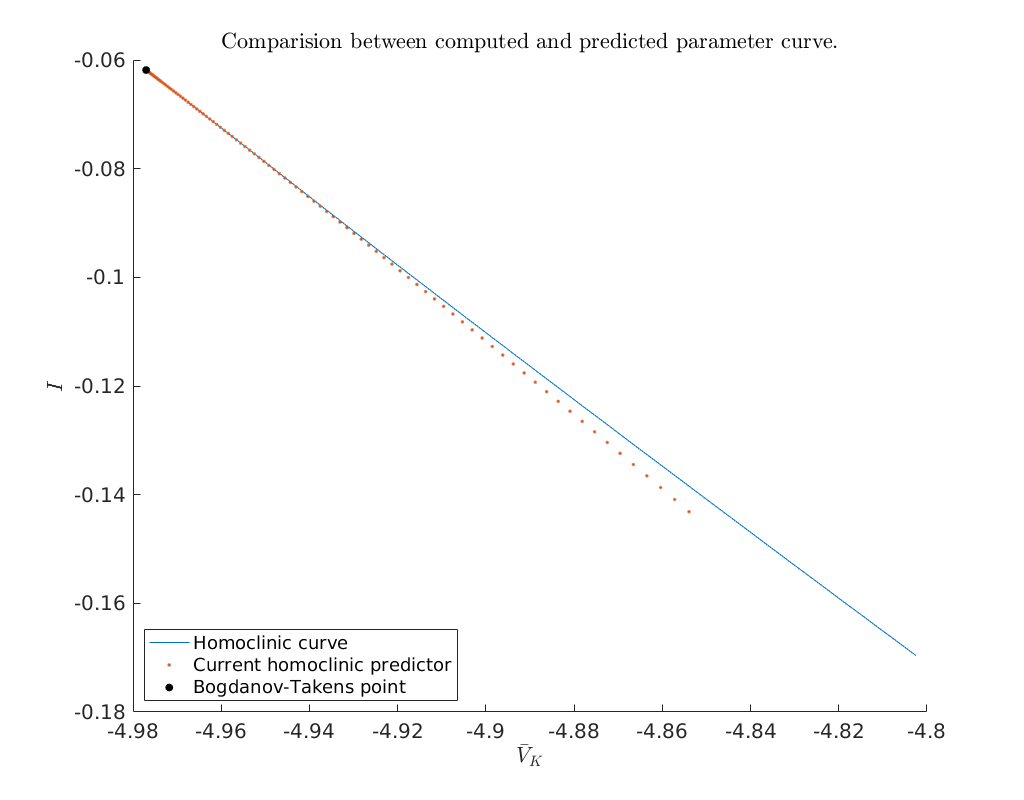

In [7]:
%plot --width 1024 --height 800
hold on
global homds
% plot computed parameter curve
plot(homoclinic_br1(homds.PeriodIdx+1,:), ...
     homoclinic_br1(homds.PeriodIdx+2,:));
% Bogdanov-Takens parameter-dependent normal form coefficients
bt1 = BT_nmfm_orbital(odefile, bt1, ap, BToptions);
a   = bt1.nmfm.a;
b   = bt1.nmfm.b;
K10 = bt1.nmfm.K10;
K01 = bt1.nmfm.K01;
K02 = bt1.nmfm.K02;
K11 = bt1.nmfm.K11;
K03 = bt1.nmfm.K03;
% construct predictor as in the paper
eps = linspace(0, 0.8);
beta1 = -4*a^3/b^4*eps.^4;
tau0  = 10/7;
tau2  = 288/2401;
beta2 = a/b*(tau0 + tau2*eps.^2).*eps.^2;
alpha = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2 + 1/6*K03.*beta2.^3;
alpha = bt1.par(ap) + alpha;
% plot currect predictor
plot(alpha(1,:), alpha(2,:), '.')
% plot Bogdanov-Takens point
plot(bt1.par(ind.VbarK), bt1.par(ind.I), '.k', 'MarkerSize', 20)
% set axis labels and legend
xlabel('$\bar{V}_K$')
ylabel('$I$')
legend({'Homoclinic curve', 'Current homoclinic predictor', ...
    'Bogdanov-Takens point'}, 'Location', 'SouthWest')
title('Comparision between computed and predicted parameter curve.')

(HH-continued-homoclinic-solutions-phase-space)= 
## Plot of continued homoclinic solutions

To obtain an impression of the  homoclinic solutions we plot the computed
homoclinic orbits in $(m,n,h)$ phase-space.

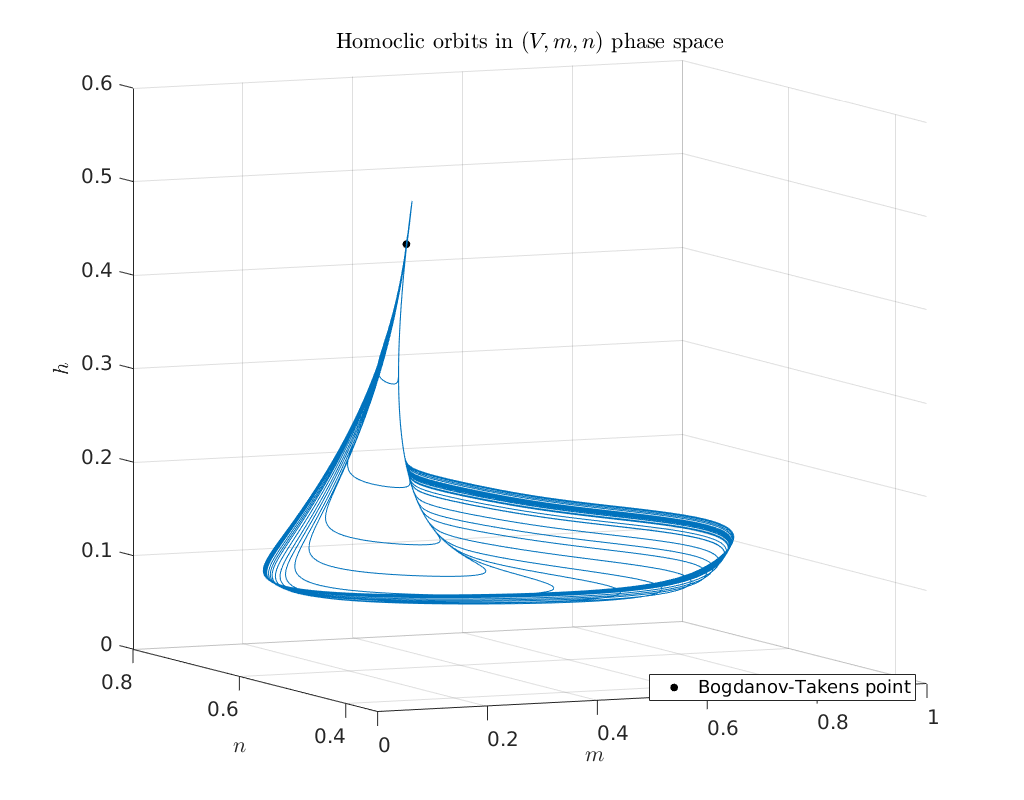

In [8]:
hold on
plot3(homoclinic_br1(homds.coords(2:homds.nphase:end), 1:10:end), ...
      homoclinic_br1(homds.coords(3:homds.nphase:end), 1:10:end), ...
      homoclinic_br1(homds.coords(4:homds.nphase:end), 1:10:end), ...
     'Color', [0 0.4470 0.7410], 'HandleVisibility', 'Off')
xlabel('$m$')
ylabel('$n$')
zlabel('$h$')
plot3(bt1.x(2), bt1.x(3), bt1.x(4), '.k' ,'MarkerSize', 20)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(V,m,n)$ phase space')
grid on
view([-24, 7]);

### Predictors of orbits for various epsilons

Below we compute for a range of amplitudes the predicted and corrected
homoclinic solutions and compare them in phase space. As seen from the plot
[above](HH-continued-homoclinic-solutions-phase-space) the homoclinic
solutions start to deform rather quickly. Therefore, we cannot expect the
approximation to be accurate for relative large amplitude values. Still, for
an amplitude of $0.3$ the approximation is nearby the corrected homoclinic
solutions.

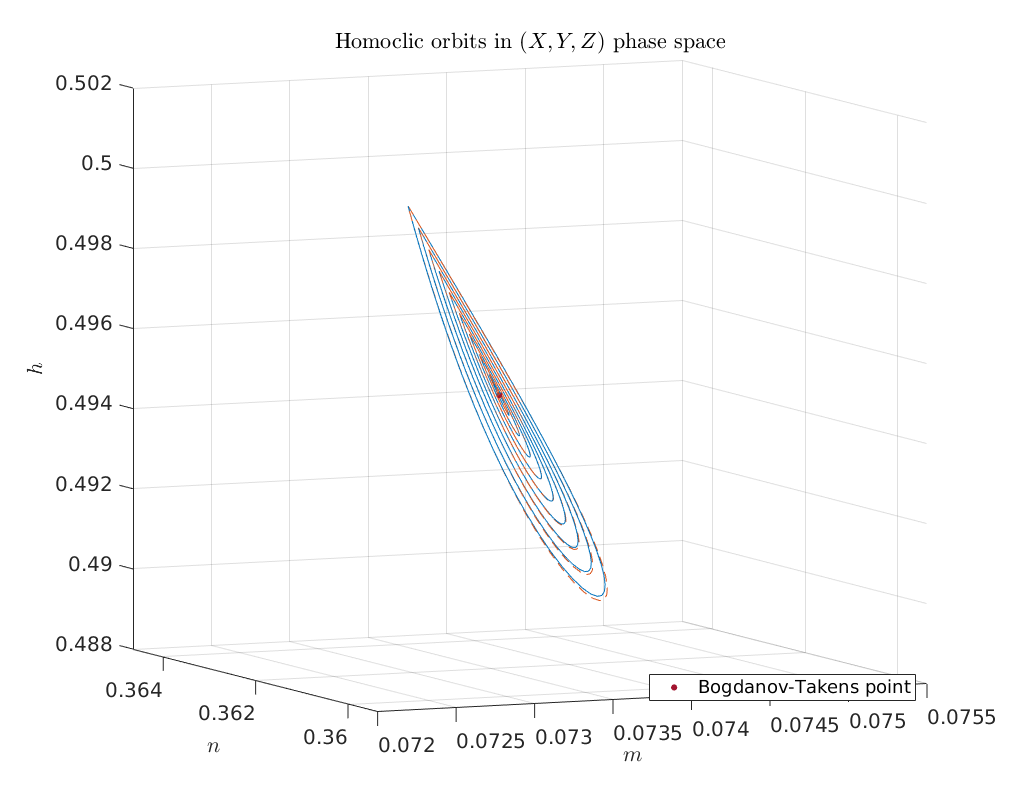

In [9]:
options = BT_Hom_set_options();
options.messages = false;
options.correct = false;
options.TTolerance = 1.0e-05;

amplitudes = linspace(1.0e-03, 0.3, 10);
XPredicted = zeros(658,length(amplitudes));
XCorrected = zeros(658,length(amplitudes));
for j=1:length(amplitudes)
  options.amplitude = amplitudes(j);
  [x_pred, v0] = init_BT_Hom(odefile, bt1, ap, options);
  XPredicted(:,j) = x_pred;
  try
    XCorrected(:,j) = newtcorr(x_pred, v0);
  catch
    warning('Didn''t convergence to homoclinic solution')
  end
end

hold on
cm = lines;
plot3(XPredicted(homds.coords(2:homds.nphase:end),1:10), ...
      XPredicted(homds.coords(3:homds.nphase:end),1:10), ...
      XPredicted(homds.coords(4:homds.nphase:end),1:10), ...
      'color', cm(1,:), 'HandleVisibility', 'Off')
plot3(XCorrected(homds.coords(2:homds.nphase:end),1:10), ...
      XCorrected(homds.coords(3:homds.nphase:end),1:10), ...
      XCorrected(homds.coords(4:homds.nphase:end),1:10), ...
      '--', 'color', cm(2,:), 'HandleVisibility', 'Off')
plot3(bt1.x(2), bt1.x(3), bt1.x(4), '.', 'MarkerSize', 16)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(X,Y,Z)$ phase space')
xlabel('$m$')
ylabel('$n$')
zlabel('$h$')
grid on
view([-24, 7]);

## Convergence plot

We finish this notebook with a log-log convergence plot comparing the different
third order homoclinic approximation methods derived in {cite}`Bosschaert@2021`
to approximate the homoclinic solutions near the first Bogdanov-Takens point.
On the abscissa is the amplitude $A_0$ and on the ordinate the relative error
$\delta$ between the constructed solution (`x_pred`) to the defining system for the
homoclinic orbit and the Newton corrected solution (`x_corrected`).

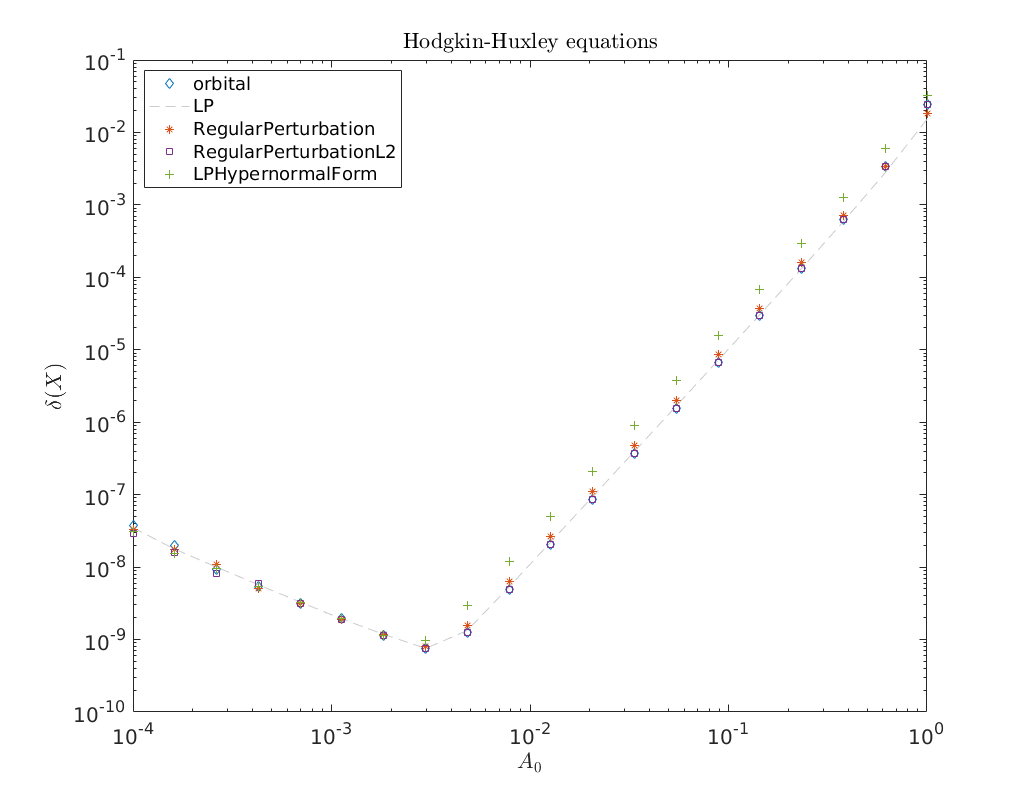

In [10]:
BToptions = BT_Hom_set_options();
BToptions.TTolerance = 1e-05;
BToptions.messages = false;
BToptions.correct = false;

amplitudes = logspace(-4, 0, 20);
methodList = {'orbital', 'LP', 'RegularPerturbation', ...
    'RegularPerturbationL2', 'LPHypernormalForm'};
relativeErrors = {};
for i=1:length(methodList)
    BToptions.method = methodList{i};
    relativeErrors{i} = zeros(size(amplitudes));
    for j=1:length(amplitudes)
    BToptions.amplitude = amplitudes(j);
    [x_pred, v0] = init_BT_Hom(odefile, bt1, ap, BToptions);
    try
        x_corrected = newtcorr(x_pred, v0);
        relativeErrors{i}(j) = norm(x_corrected-x_pred)/norm(x_corrected);
    catch
        warning('Did not converge.')
        continue
    end
  end
end

cm = lines();
loglog(amplitudes, relativeErrors{1}(:), 'd', ...
       amplitudes, relativeErrors{2}(:), '--', ...
       amplitudes, relativeErrors{3}(:), '*', ...
       amplitudes, relativeErrors{4}(:), 's', ...
       amplitudes, relativeErrors{5}(:), '+')
legend(methodList, 'Location', 'NorthWest')
title('Hodgkin-Huxley equations')
xlabel('$A_0$')
ylabel('$\delta(X)$')
ax = gca;
ax.ColorOrder = [cm(1,:); [0.8 0.8 0.8]; cm(2,:); cm(4,:); cm(5,:)];